In [1]:
# Import needed packages for analysis
import os

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib
from sklearn.preprocessing import StandardScaler

import cfl.util.brain_util as BU
import cfl.util.brain_vis as BV
from cfl.util import fear_mice_functions as fm
from cfl.util.fear_mice_functions import get_global_values


mri_dir, mri_dims, affine, dir_labels = get_global_values()

# load the non-linear mask template
nl_mask_path = os.path.join('PTSD_Data_Share/templates\MuseTemplate_nonlinear_mask.nii')
nl_mask = BU.load_brain(nl_mask_path, ori='RPS')
nolin_mask_vec = BU.flatten(nl_mask)

In [2]:
# load response data 
Y = pd.read_pickle('Y.pkl')

# # load all the images 
X = np.load('smooth_X_paper_sigma.npy')

folder_path = os.path.join('npy_files', 'smooth')
data_id = 'smooth_X_'

In [4]:
indices_dir = fm.timepoint_indices_dir(Y)

# load smoooth fear minus pre-fear MRIs 
X_diffs = X[indices_dir['Fear']] - X[indices_dir['PreF']]

# load fear minus pre-fear response data 
Y_diffs = Y.PerLight[indices_dir['Fear']].to_numpy() - Y.PerLight[indices_dir['PreF']].to_numpy()
Y_diffs = np.expand_dims(Y_diffs, -1) #expand to make it 2d

# center the data 
X_diffs_t = StandardScaler().fit_transform(X_diffs)
Y_diffs_t = StandardScaler().fit_transform(Y_diffs)

 - Calculate the regressions for (fear - pre-fear) MRI activation & (fear - pre-fear) Response (time spent in the light)   

- Voxel-wise across all the voxels of the brain    

- 20 pairs of data (1 for each mouse)   

- Using Gaussian smoothed brain data    

In [3]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold


In [6]:
## do this for only the amygdala voxels 
atlas = BU.load_brain(os.path.join('PTSD_Data_Share', "PTSD_InVivoAtlas_labels.nii"), ori='RPS')
atlas_names_df = pd.read_excel(os.path.join('C:/Users/jkahn/Documents/Schmidt/cfl/cfl_examples/fear_mice/PTSD_Data_Share/PTSD_InVivoAtlas_labels_grouping_mod.xlsx'))

def find_regions(region_name):
    # find matches to region_name in the full names for the atlas  
    matching_fullnames = atlas_names_df['Grouping'].str.contains(region_name)
    #get the numbers (as seen in atlas) for those regions 
    region_numbers = atlas_names_df.Original_Invivo_Index[matching_fullnames].to_numpy()
    return region_numbers



amyg_regions = find_regions('Amygdala')
amyg_regions = amyg_regions.tolist()

In [ ]:
flatlas = BU.flatten(atlas)

In [ ]:
# amyg_voxels is a mask w/ the dimensions of 1 mri 
# that has 0s wherever any voxel not in the MRI is  
amyg_voxels = np.where(np.isin(flatlas, amyg_regions), flatlas, 0)

In [ ]:
# then mask X so that it is NaNs whereever it is not amygdala
amyg_mask = np.ma.masked_equal(amyg_voxels, 0)

In [7]:
def threeD_index_to_flat(i, dim): 
    return i[0] * (dim[1]*dim[2]) + i[1] * dim[2] + i[2]

def do_regression(X_diffs, Y_diffs, mask, reg_model):
    '''
    X_diffs (array): np array with dim (n_samples, n_voxels)
    Y_diffs (array): np.array with dim (n_sampels, 1)
    reg_model : a regression model 
    '''
    n_voxels = X_diffs.shape[1]

    # return values will be stored in these arrays 
    coefs= np.zeros(n_voxels) 
    alphas = np.zeros(n_voxels)

    #do the regression, voxelwise
    for voxel in tqdm(range(n_voxels)): 
        if mask[voxel] != 0: #skip the masked voxels

            #make the activations for a single voxel into 2D array
            x = np.expand_dims(X_diffs[:, voxel], -1)

            reg_model.fit(X=x, y=Y_diffs)
            coefs[voxel] = reg_model.coef_
            alphas[voxel] = reg_model.alpha_
    return coefs, ints, alphas

## Ridge Regression

In [ ]:
# # define ridge regression model 
# # test alpha values from 0 to 5
# ridge_model = RidgeCV(alphas=np.arange(0.1, 5, 0.25), fit_intercept=False)

# ridge_coef, ridge_ints, ridge_alpha = do_regression(X_diffs_t, Y_diffs_t, nolin_mask_vec, ridge_model)

In [ ]:
np.unique(ridge_alpha)

In [ ]:
# np.save(os.path.join(folder_path, data_id + "ridge_reg_coefs.npy"), ridge_coef)
# np.save(os.path.join(folder_path, data_id + "ridge_reg_alpha.npy"), ridge_alpha)

# fm.save_as_nifti(ridge_coef, data_id+"ridge_reg_coefs.nii", mri_dims, affine)
# fm.save_as_nifti(ridge_alpha,  data_id+"ridge_reg_alpha.nii", mri_dims, affine)

In [8]:
ridge_coef = np.load(os.path.join(folder_path, data_id + "ridge_reg_coefs.npy"))
ridge_alpha = np.load(os.path.join(folder_path, data_id + "ridge_reg_alpha.npy"))

In [ ]:
BV.plot_interactive_panels(ridge_coef, mri_dims, nolin_mask_vec, figsize=(12, 3), std_scale='std', dir_labels=dir_labels, column_titles=["Ridge Regression"])

In [ ]:
Y_diffs_og = np.reshape(Y_diffs, 20)

In [9]:
from sklearn.linear_model import LinearRegression

def graph_one_voxel_scatter(voxel_loc, reg_coefs, reg_ints, reg_alpha, X_diffs, Y_diffs, mri_dims, reg_type="Ridge"): 
    '''voxel location is a 3-tuple/list/array that gives 3-D index of voxel location 
    in MRI 

    reg_coefs is an array with dims (mri_dims) that has the coefficients for a voxel-wise regression. 
    reg_ints is an array with dims (mri_dims) that has the y-intercepts from the same voxel-wise regression
    '''

    flat_vox_ind = threeD_index_to_flat(voxel_loc, mri_dims)

    # scatter plot the points 
    plt.scatter(X_diffs[:, flat_vox_ind], Y_diffs)
    
    # graph the ridge regression line
    coef = reg_coefs[flat_vox_ind]
    yint = reg_ints[flat_vox_ind]
    plt.axline(xy1=(0, yint), slope=coef)

    # compare the linear regression line 
    lr = LinearRegression(fit_intercept=False).fit(np.expand_dims(X_diffs[:, flat_vox_ind], -1), Y_diffs)
    # plt.axline(xy1=(0, lr.intercept_[0]), slope=lr.coef_[0][0], color="red", linestyle=(0, (5, 5)))
    plt.axline(xy1= (0, 0), slope=lr.coef_[0][0], color="red", linestyle=(0, (5, 5)))

    plt.suptitle("Fear - PreF MRI activity vs response values")
    plt.xlabel("Normalized Difference in MRI Activation")
    plt.ylabel("Normalized Difference in time spent in light")
    plt.show()

    # print('Ridge regression: y={slope}x + {int}, Lambda={lamba}\n LS regression: y={lsslope}x + {lsint} \n Blue line is regression of interest; red dotted line is least squares regression, for comparison'.format(slope=coef, int=yint, lamba=rg_alpha_unflat[voxel_loc], lsslope=lr.coef_[0][0], lsint=lr.intercept_[0]))]
    print('{type} regression: y={slope}x , Lambda={lamba}\n LS regression: y={lsslope}x \n Blue line is regression of interest; red dotted line is least squares regression, for comparison'.format(slope=coef, lamba=np.around(reg_alpha[flat_vox_ind], 2), lsslope=lr.coef_[0][0], type=reg_type))



In [ ]:
graph_one_voxel_scatter((86, 93, 18), ridge_coef, ridge_ints, ridge_alpha, X_diffs_t, Y_diffs_t, mri_dims)

In [ ]:
# compare the linear regression line 
voxel_loc = (86, 93, 18)
X_diffs_unflat = np.reshape(X_diffs_t, (X_diffs.shape[0], ) + mri_dims)

lr = RidgeCV(alphas=np.arange(0.1, 10, 0.5)).fit(np.expand_dims(X_diffs_unflat[:, voxel_loc[0], voxel_loc[1], voxel_loc[2]], -1), Y_diffs_t)
# print(lr.intercept_[0], lr.coef_[0][0])
print(lr.coef_, lr.intercept_, lr.alpha_)


In [ ]:
graph_one_voxel_scatter((49, 104, 53), ridge_coef, ridge_ints, ridge_alpha, X_diffs_t, Y_diffs_t, mri_dims)

In [ ]:
graph_one_voxel_scatter((50, 99, 60), ridge_coef, ridge_ints, ridge_alpha, X_diffs_t, Y_diffs_t, mri_dims)

# Laso Regression 

In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold

In [ ]:
# test alpha values from 0 to 1 
lasso_model = LassoCV(alphas=np.arange(0.1, 1, 0.1))

In [ ]:
# lasso_coef, lasso_int, lasso_alphas = do_regression(X_diffs_t, Y_diffs_t, nolin_mask_vec, lasso_model)


In [ ]:
np.save(os.path.join(folder_path, data_id + "lasso_reg_coefs.npy"), lasso_coef)
np.save(os.path.join(folder_path, data_id + "lasso_reg_alpha.npy"), lasso_alphas)

fm.save_as_nifti(lasso_coef, data_id+"lasso_reg_coefs.nii", mri_dims, affine)
fm.save_as_nifti(lasso_alphas, data_id+"lasso_reg_alphas.nii", mri_dims, affine)

In [ ]:
graph_one_voxel_scatter((86, 93, 18), lasso_coef, lasso_int, lasso_alphas, X_diffs_t, Y_diffs_t, mri_dims, "Lasso")

In [ ]:
graph_one_voxel_scatter((49, 104, 53), lasso_coef, lasso_int, lasso_alphas, X_diffs_t, Y_diffs_t, mri_dims, "Lasso")

In [ ]:
graph_one_voxel_scatter((50, 99, 60), lasso_coef, lasso_int, lasso_alphas, X_diffs_t, Y_diffs_t, mri_dims, "Lasso")

# Decision Tree 


In [10]:
def do_dec_tree(X_diffs, Y_diffs, mask, max_depth=None):
    '''
    X_diffs (array): np array with dim (n_samples, n_voxels)
    Y_diffs (array): np.array with dim (n_sampels, 1)
    '''
    dec_tree = DecisionTreeRegressor(max_depth=max_depth)

    n_voxels = X_diffs.shape[1]

    # return values will be stored in these arrays 
    fitted_mods = []
    feat_imps = np.zeros(n_voxels)
    alphas = np.zeros(n_voxels)

    #do the regression, voxelwise
    for voxel in tqdm(range(n_voxels)): 
        if mask[voxel] != 0: #skip the masked voxels

            #make the activations for a single voxel into 2D array
            x = np.expand_dims(X_diffs[:, voxel], -1)

            dec_tree.fit(X=x, y=Y_diffs)
            fitted_mods.append(dec_tree)
            feat_imps[voxel] = dec_tree.feature_importances_
        else: 
            fitted_mods.append(np.nan)
    return fitted_mods, feat_imps

In [11]:
from sklearn.tree import DecisionTreeRegressor

braintree = DecisionTreeRegressor()
braintree.fit(X_diffs, Y_diffs)

DecisionTreeRegressor()

[Text(199.10454545454547, 201.90857142857143, 'X[1341339] <= 1.556\nmse = 0.03\nsamples = 20\nvalue = -0.195'),
 Text(119.20909090909092, 170.84571428571428, 'X[1466227] <= 50.52\nmse = 0.01\nsamples = 13\nvalue = -0.089'),
 Text(65.94545454545455, 139.78285714285715, 'X[1015602] <= -0.01\nmse = 0.002\nsamples = 9\nvalue = -0.147'),
 Text(20.290909090909093, 108.72, 'X[998060] <= -510.223\nmse = 0.0\nsamples = 4\nvalue = -0.1'),
 Text(10.145454545454546, 77.65714285714284, 'mse = 0.0\nsamples = 1\nvalue = -0.129'),
 Text(30.436363636363637, 77.65714285714284, 'X[1716291] <= 48.222\nmse = 0.0\nsamples = 3\nvalue = -0.09'),
 Text(20.290909090909093, 46.59428571428572, 'mse = 0.0\nsamples = 1\nvalue = -0.081'),
 Text(40.581818181818186, 46.59428571428572, 'X[926124] <= 280.594\nmse = 0.0\nsamples = 2\nvalue = -0.095'),
 Text(30.436363636363637, 15.531428571428563, 'mse = 0.0\nsamples = 1\nvalue = -0.099'),
 Text(50.727272727272734, 15.531428571428563, 'mse = -0.0\nsamples = 1\nvalue = -0.

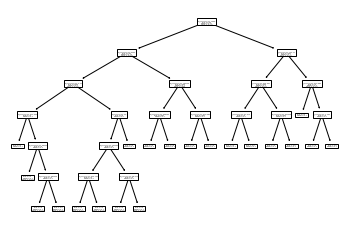

In [12]:
from sklearn import tree 
tree.plot_tree(braintree) 

# Thresholding regions with Ridge Regression 

In [13]:
def plot_cluster_bar(df): 
    xs = df["Cluster Index"].to_numpy()
    ys = df.Voxels.to_numpy()

    sort_inds = np.flip(np.argsort(xs))
    sorted_xs = xs.ravel()[sort_inds.reshape(xs.shape)]
    sorted_ys = ys.ravel()[sort_inds.reshape(ys.shape)]

    plt.figure(figsize=(19, 4))
    plt.bar(sorted_xs.astype(int).astype(str), height=sorted_ys)
    plt.suptitle("Size of each 'significant' cluster in the ridge regression Alphas")
    plt.xticks([])
    plt.ylabel("Number of Voxels in cluster")
    plt.xlabel("Index")
    plt.show()


In [14]:
# ridge_alpha_mask = boolean array of 0s where the lambda has 'whited out' the slope (drawn it towards 0) and 1 if it isn't 
high_lambda = np.percentile(ridge_alpha, 99)
print(high_lambda)
ridge_alpha_mask = np.where(np.around(ridge_alpha, 2) >= high_lambda, 0, 1)

# save this array as a nii and run fsl cluster 
# clustering command: cluster --in=smooth_X_ridge_alpha_mask.nii --thresh=1 > clusters_smooth_X_ridge_alphas.txt
fm.save_as_nifti(ridge_alpha_mask, data_id + "ridge_alpha_mask.nii", mri_dims, affine)

4.849999999999999


In [15]:
# load csv file with data in 
ridge_clusters = pd.read_excel("clusters_" + data_id +"ridge_alphas.xlsx")

# remove the cluster for all the empty space outside the brain (big)
ridge_clusters = ridge_clusters[ridge_clusters.Voxels < 10000]

ridge_clusters

,Cluster Index,Voxels,MAX,MAX X (vox),MAX Y (vox),MAX Z (vox),COG X (vox),COG Y (vox),COG Z (vox)
1,276,2871,1,70,106,15,88.3,107.0,33.6
2,275,2602,1,29,145,38,59.0,135.0,51.5
3,274,2517,1,77,80,43,68.4,72.6,57.8
4,273,1485,1,47,110,45,50.6,109.0,51.2
5,272,1054,1,50,155,15,52.2,150.0,21.5
...,...,...,...,...,...,...,...,...,...
272,5,1,1,54,167,27,54.0,167.0,27.0
273,4,1,1,45,75,47,45.0,75.0,47.0
274,3,1,1,35,136,28,35.0,136.0,28.0
275,2,1,1,98,96,46,98.0,96.0,46.0


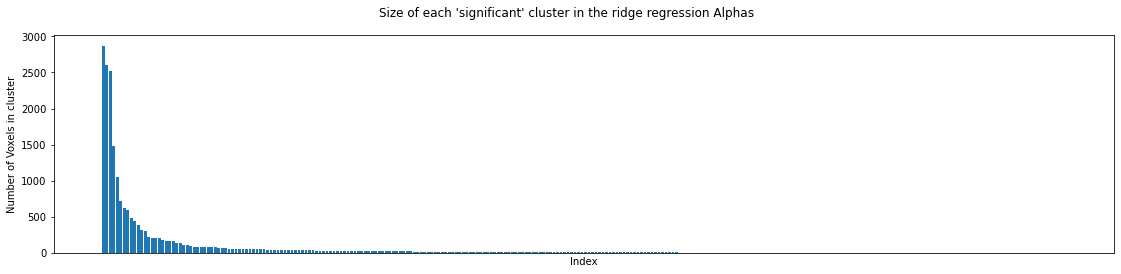

In [16]:
# graph all the clusters to see their sizes 
plot_cluster_bar(ridge_clusters)

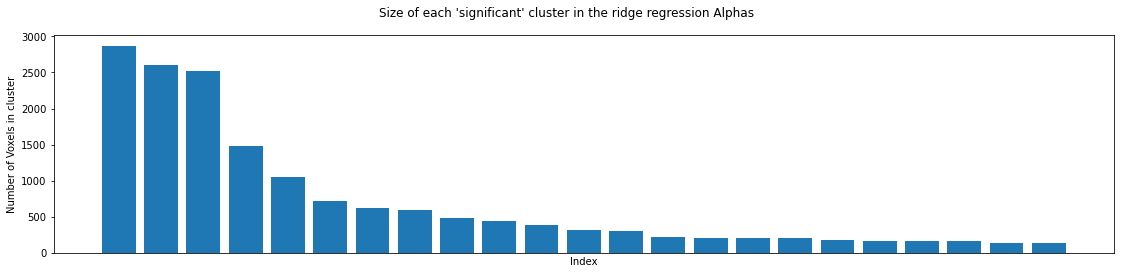

Number of remaining clusters: 23


In [17]:
# remove all clusters with fewer than <threshold> voxels
# 128 is the voxel threshold used by the paper  
threshold = 128 
trimmed_ridge_clusters = ridge_clusters[ridge_clusters.Voxels > threshold]

plot_cluster_bar(trimmed_ridge_clusters)

# how many clusters left? 
print("Number of remaining clusters:", trimmed_ridge_clusters.Voxels.count())

In [18]:
# where are the biggest few clusters? 
# three biggest clusters
trimmed_ridge_clusters[:3]

,Cluster Index,Voxels,MAX,MAX X (vox),MAX Y (vox),MAX Z (vox),COG X (vox),COG Y (vox),COG Z (vox)
1,276,2871,1,70,106,15,88.3,107.0,33.6
2,275,2602,1,29,145,38,59.0,135.0,51.5
3,274,2517,1,77,80,43,68.4,72.6,57.8


In [19]:
# # install skimage 
# import sys
# !conda install --yes --prefix {sys.prefix} scikit-image

from skimage.segmentation import flood

unflat_alphas_mask = BU.unflatten(ridge_alpha_mask, mri_dims)
where_are_NaNs = np.isnan(unflat_alphas_mask)
unflat_alphas_mask[where_are_NaNs] = 0

In [20]:
location_of_big_cluster = [(70, 106, 15), (29, 145, 38), (77, 80, 43)] 

biggest_clusters_mask = np.zeros(unflat_alphas_mask.shape)
counter = 1
for voxel in location_of_big_cluster: 
    mask = flood(unflat_alphas_mask, voxel) 
    biggest_clusters_mask[mask] = counter 
    counter +=1

fm.save_as_nifti(biggest_clusters_mask, 'biggest_cluster_locations.nii', mri_dims, affine)


# # create a mask where the atlas number is left the same if that value is in the most imp names, otherwise 0 

# for each important region: 
# how many non-zeroed alphas intersect with that region relative to total # of voxels in that region? 


In [21]:
# create mask for all clusters > 128 voxels
def cluster_mask(cluster_df, alphas_mask): 
    '''alphas_mask should be 3D'''
    clusters_mask = np.zeros(alphas_mask.shape)

    for i, row in cluster_df.iterrows(): 
        location_of_cluster = (int(row["MAX X (vox)"]), int(row["MAX Y (vox)"]), int(row["MAX Z (vox)"]))

        mask = flood(unflat_alphas_mask, location_of_cluster) 
        clusters_mask[mask] = (i) 
    return clusters_mask


In [22]:
# create mask for all clusters > 128 voxels
cluster_masked = cluster_mask(trimmed_ridge_clusters, unflat_alphas_mask)

fm.save_as_nifti(cluster_masked, data_id + "all_ridge_clusters.nii",mri_dims, affine)

In [ ]:
np.unique(cluster_masked)

In [23]:
def percent_overlap(mask1, mask2): 
    '''create a array that shows the percent overlap for each region in mask1 with each region in mask2'''
    # create a new array with the regions in mask2 as the column titles and the regions in mask1 as the rows
    mask1_regions = np.unique(mask1)
    mask2_regions = np.unique(mask2)

    return_array = np.zeros((len(mask1_regions), len(mask2_regions)))

    assert mask1.shape==mask2.shape, "make sure both arrays are same shape"
    # for each voxel in mask1: 
    it = np.nditer(mask1, flags=['multi_index'])
    for voxel in it:
        mask1_index = np.where(mask1_regions==voxel)[0][0]

        # mask2_index should be..... for this 
        mask2_voxel = mask2[it.multi_index]
        mask2_index = np.where(mask2_regions==mask2_voxel)[0][0]

        # add 1 to the array for the appropriate voxel in mask2 
        return_array[mask1_index][mask2_index] += 1

    # divide each entry by the number of total voxels for that region in mask1 
    for i, row in enumerate(return_array): 
        voxels_in_this_region = np.sum(mask1==mask1_regions[i])
        return_array[i] = np.divide(row, voxels_in_this_region)

    return {"rows": mask1_regions, "cols": mask2_regions, "values": return_array}

In [24]:
# then do 'best reciprocal hit' method 
cluster_to_atlas = percent_overlap(cluster_masked, atlas)

atlas_to_cluster = percent_overlap(atlas, cluster_masked)

In [25]:

cluster_regions = cluster_to_atlas['rows']
atlas_regions = cluster_to_atlas['cols']
overlap_array = cluster_to_atlas['values']
# find the non-zero values and print them 

threshold = 25
print("Printing only clusters that are located at least", str(threshold)+"% within a single atlas region")
for i, row in enumerate(overlap_array): 
    if i != 0: #skip the 0th cluster (not a cluster)
        for j, entry in enumerate(row):
            if np.around(overlap_array[i][j]*100) > 25: 
                print('Cluster number:', cluster_regions[i], 'size:', np.sum(cluster_masked==cluster_regions[i]), "voxels")

                print('\t Atlas region:', atlas_regions[j], 'size:', np.sum(atlas==atlas_regions[j]), "voxels")
                print("\t percent overlap from cluster to region: ", np.around(overlap_array[i][j]*100, 4)) 
                print('\t percent overlap from region to cluster:', np.around(atlas_to_cluster['values'][j][i], 4))


Printing only clusters that are located at least 25% within a single atlas region
Cluster number: 1.0 size: 2871 voxels
	 Atlas region: 26.0 size: 20912 voxels
	 percent overlap from cluster to region:  31.3131
	 percent overlap from region to cluster: 0.043
Cluster number: 2.0 size: 2602 voxels
	 Atlas region: 3.0 size: 19705 voxels
	 percent overlap from cluster to region:  43.3513
	 percent overlap from region to cluster: 0.0572
Cluster number: 2.0 size: 2602 voxels
	 Atlas region: 95.0 size: 4419 voxels
	 percent overlap from cluster to region:  36.5488
	 percent overlap from region to cluster: 0.2152
Cluster number: 5.0 size: 1054 voxels
	 Atlas region: 4.0 size: 23892 voxels
	 percent overlap from cluster to region:  91.2713
	 percent overlap from region to cluster: 0.0403
Cluster number: 6.0 size: 715 voxels
	 Atlas region: 107.0 size: 16017 voxels
	 percent overlap from cluster to region:  41.8182
	 percent overlap from region to cluster: 0.0187
Cluster number: 6.0 size: 715 vo

In [ ]:
print(cluster_to_atlas['values'])

In [ ]:
# Where are most important regions from paper, relative to the non-zeroed out regions from ridge regression ?

In [ ]:
# choose 4-5 most important regions 

# map the name to values in atlas 

# find where those values are in the atlas 

# create a mask where the atlas number is left the same if that value is in the most imp names, otherwise 0 

# then visualize the mask overlaid on the ridge regression alphas and coefs in FSLEyes

# for each important region: 
# how many non-zeroed alphas intersect with that region relative to total # of voxels in that region? 
